In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, Predictive
from pyro.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam




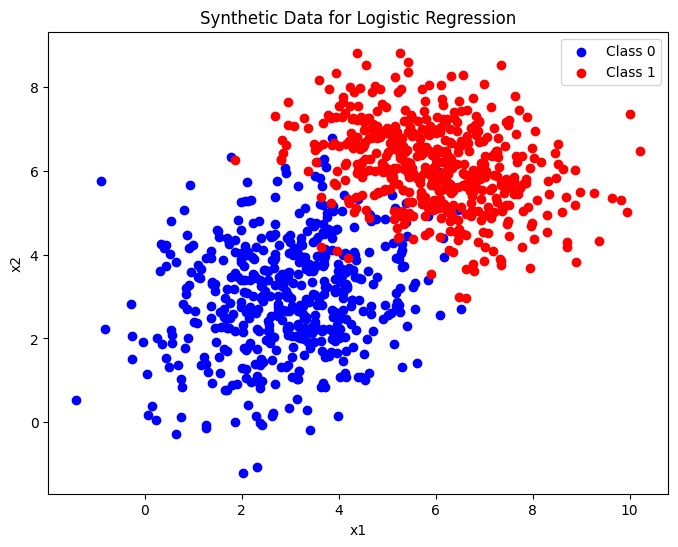

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate 100 samples for each class
n_samples = 500

# Class 0: Centered around (2, 2)
x0 = np.random.multivariate_normal([3, 3], [[2, 0.5], [0.5, 2]], n_samples)
y0 = np.zeros(n_samples)

# Class 1: Centered around (6, 6)
x1 = np.random.multivariate_normal([6, 6], [[2, -0.5], [-0.5, 1]], n_samples)
y1 = np.ones(n_samples)

# Combine the data
X = np.vstack((x0, x1))
y = np.hstack((y0, y1))
# Shuffle the data
indices = np.random.permutation(X.shape[0])
X, y = X[indices], y[indices]

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).type(torch.float32)
y_tensor = torch.tensor(y).type(torch.float32).reshape(-1,1)
# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Synthetic Data for Logistic Regression')
plt.show()



In [4]:
def model(X, Y=None):
    # Define the plate for batch processing
    # Sample a weight vector for two features (X has shape [n_samples, 2])
    weight = pyro.sample('weight', dist.Normal(torch.zeros(2), 0.5 * torch.ones(2)).to_event(1))
    # Sample the bias term (a scalar)
    bias = pyro.sample('bias', dist.Normal(0., 5.0))
    # Calculate logits: X @ weight + bias
    logits = X @ weight + bias*torch.ones(X.shape[0])
    Y = Y.squeeze(-1)
    # Sample observed labels with Bernoulli likelihood
    with pyro.plate(X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(logits=logits), obs=Y)


def guide(X, Y=None):
    # Learnable parameters for the weight vector
    weight_loc = pyro.param('weight_loc', torch.zeros(2))
    weight_scale = pyro.param('weight_scale', torch.ones(2), 
                              constraint=dist.constraints.positive)

    # Learnable parameters for the bias term
    bias_loc = pyro.param('bias_loc', torch.tensor(0.0))
    bias_scale = pyro.param('bias_scale', torch.tensor(10.0), 
                            constraint=dist.constraints.positive)

    # Sample parameters from the variational distributions
    pyro.sample('weight', dist.Normal(weight_loc, weight_scale).to_event(1))
    pyro.sample('bias', dist.Normal(bias_loc, bias_scale))


Step 0 - Train Loss: 8.66
Step 50 - Train Loss: 5.91
Step 100 - Train Loss: 7.79
Step 150 - Train Loss: 8.45
Step 200 - Train Loss: 8.22
Step 250 - Train Loss: 8.19
Step 300 - Train Loss: 6.42
Step 350 - Train Loss: 7.12
Step 400 - Train Loss: 6.05
Step 450 - Train Loss: 7.01
Step 500 - Train Loss: 5.99
Step 550 - Train Loss: 6.16
Step 600 - Train Loss: 6.50
Step 650 - Train Loss: 6.00
Step 700 - Train Loss: 5.81
Step 750 - Train Loss: 5.85
Step 800 - Train Loss: 6.78
Step 850 - Train Loss: 6.18
Step 900 - Train Loss: 6.27
Step 950 - Train Loss: 5.71
Step 1000 - Train Loss: 6.42
Step 1050 - Train Loss: 6.24
Step 1100 - Train Loss: 6.04
Step 1150 - Train Loss: 6.33
Step 1200 - Train Loss: 6.43
Step 1250 - Train Loss: 5.92
Step 1300 - Train Loss: 5.71
Step 1350 - Train Loss: 5.85
Step 1400 - Train Loss: 5.69
Step 1450 - Train Loss: 6.33
Step 1500 - Train Loss: 5.86
Step 1550 - Train Loss: 5.73
Step 1600 - Train Loss: 5.85
Step 1650 - Train Loss: 5.92
Step 1700 - Train Loss: 5.60
Step 175

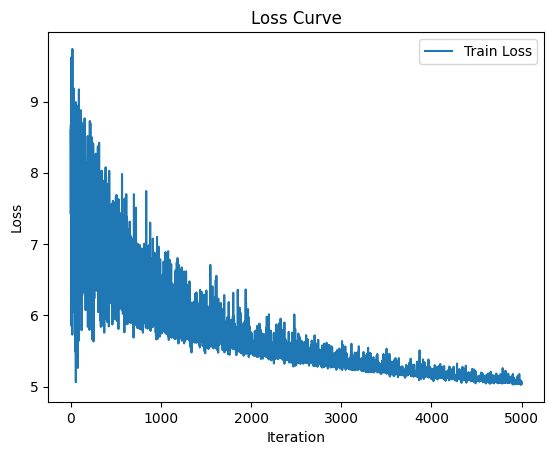

In [8]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

num_iterations = 5000
train_losses = []
val_losses = []
w = torch.zeros(2,2,int(num_iterations/50))
b = torch.zeros(1,2,int(num_iterations/50))
for step in range(num_iterations):

    train_loss = svi.step(X_tensor, y_tensor)
    train_losses.append(np.log(train_loss))



    if step % 50 == 0:
        print(f"Step {step} - Train Loss: {np.log(train_loss):.2f}")
        # Extract inferred parameters from Pyro's param store
        param_store = pyro.get_param_store()
        weight_loc = param_store["weight_loc"].detach()
        weight_scale = param_store["weight_scale"].detach()
        bias_loc = param_store["bias_loc"].item()
        bias_scale = param_store["bias_scale"].item()
        w[:,0,int(step/50)] = weight_loc
        w[:,1,int(step/50)] = weight_scale
        b[:,0,int(step/50)] = bias_loc
        b[:,1,int(step/50)] = bias_scale

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()



In [9]:
# Access the inferred parameters from the Pyro param store
param_store = pyro.get_param_store()

# Extract weight and bias parameters
weight_loc = param_store["weight_loc"].detach().numpy()
weight_scale = param_store["weight_scale"].detach().numpy()
bias_loc = param_store["bias_loc"].item()
bias_scale = param_store["bias_scale"].item()

print("Inferred Parameters:")
print(f"Weight Mean (loc): {weight_loc}")
print(f"Weight Scale (std): {weight_scale}")
print(f"Bias Mean (loc): {bias_loc}")
print(f"Bias Scale (std): {bias_scale}")

Inferred Parameters:
Weight Mean (loc): [0.95229083 1.1687714 ]
Weight Scale (std): [0.03573034 0.03305012]
Bias Mean (loc): -9.848522186279297
Bias Scale (std): 0.21832388639450073


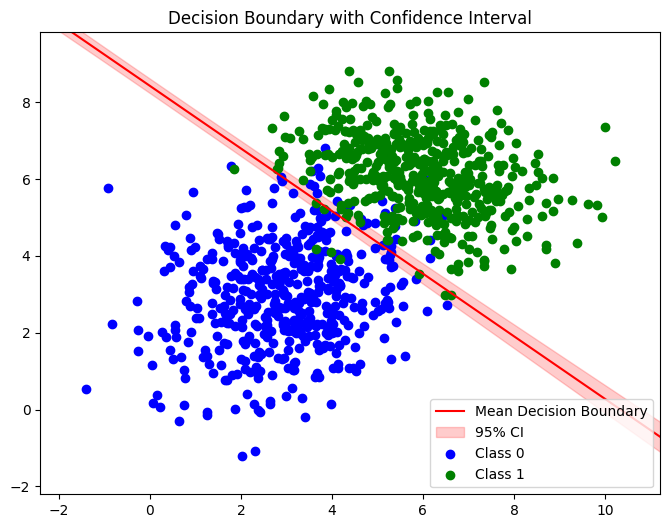

In [14]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the decision boundary with confidence intervals
def plot_decision_boundary_with_uncertainty(X, Y, weight_mean, weight_std, bias_mean, bias_std, ax):
    # Create plot limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_vals = np.linspace(x_min, x_max, 100)

    # Compute the mean decision boundary: y = -(w1 * x + b) / w2
    y_mean = -(weight_mean[0] * x_vals + bias_mean) / weight_mean[1]

    # Compute the standard deviation of the decision boundary
    # Propagate uncertainty using the formula for linear combinations of Gaussian RVs
    slope_std = np.sqrt(
        (x_vals**2) * weight_std[0]**2 / weight_mean[1]**2 +
        weight_std[1]**2 / weight_mean[1]**4 +
        bias_std**2 / weight_mean[1]**2
    )
    
    # Compute upper and lower bounds of the 95% confidence interval
    y_upper = y_mean + slope_std
    y_lower = y_mean - slope_std

    # Plot the mean decision boundary
    ax.plot(x_vals, y_mean, 'r-', label='Mean Decision Boundary')

    # Fill the area between upper and lower bounds for the confidence interval
    ax.fill_between(x_vals, y_lower, y_upper, color='red', alpha=0.2, label='95% CI')

    # Scatter plot of data points
    ax.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', label='Class 0')
    ax.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='green', label='Class 1')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    ax.set_title('Decision Boundary with Confidence Interval')
    ax.legend()

# Extract inferred parameters from Pyro's param store
param_store = pyro.get_param_store()
weight_loc = param_store["weight_loc"].detach().numpy()
weight_scale = param_store["weight_scale"].detach().numpy()
bias_loc = param_store["bias_loc"].item()
bias_scale = param_store["bias_scale"].item()

# Plot the decision boundary with confidence interval
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary_with_uncertainty(
    X_tensor.numpy(), y_tensor.squeeze(-1).numpy(), 
    weight_mean=weight_loc, weight_std=weight_scale, 
    bias_mean=bias_loc, bias_std=bias_scale, 
    ax=ax
)
plt.show()


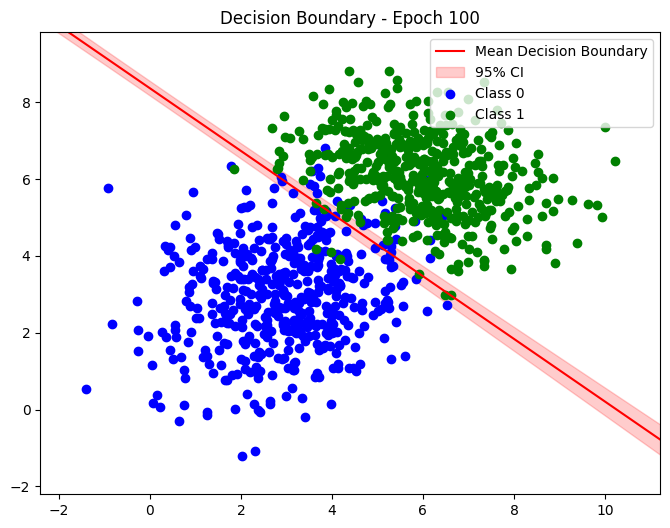

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to plot the decision boundary for a specific epoch
def plot_decision_boundary(ax, X, Y, weight_loc, weight_scale, bias_loc, bias_scale):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_vals = np.linspace(x_min, x_max, 100)

    # Mean decision boundary
    y_mean = -(weight_loc[0] * x_vals + bias_loc) / weight_loc[1]

    # Standard deviation for confidence interval
    slope_std = np.sqrt(
        (x_vals**2) * weight_scale[0]**2 / weight_loc[1]**2 +
        weight_scale[1]**2 / weight_loc[1]**4 +
        bias_scale**2 / weight_loc[1]**2
    )
    y_upper = y_mean +  slope_std
    y_lower = y_mean - slope_std

    ax.clear()  # Clear previous plots
    # Plot mean decision boundary and confidence interval
    ax.plot(x_vals, y_mean, 'r-', label='Mean Decision Boundary')
    ax.fill_between(x_vals, y_lower, y_upper, color='red', alpha=0.2, label='95% CI')

    # Scatter plot of data points
    ax.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', label='Class 0')
    ax.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='green', label='Class 1')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    ax.set_title('Decision Boundary - Epoch')
    ax.legend(loc='upper right')

# Create an animation of decision boundaries over epochs
def create_gif(X, Y, w, b, filename='decision_boundary.gif'):
    fig, ax = plt.subplots(figsize=(8, 6))
    num_epochs = w.shape[2]

    def update(epoch):
        weight_loc = w[:, 0, epoch]
        weight_scale = w[:, 1, epoch]
        bias_loc = b[0, 0, epoch]
        bias_scale = b[0, 1, epoch]
        plot_decision_boundary(ax, X, Y, weight_loc, weight_scale, bias_loc, bias_scale)
        ax.set_title(f'Decision Boundary - Epoch {epoch + 1}')

    ani = animation.FuncAnimation(fig, update, frames=num_epochs, repeat=False)
    ani.save(filename, writer='pillow', fps=5)  # Save the animation as a GIF
w_np = w.numpy()
b_np = b.numpy()
# Assuming X and Y are your data tensors
# Example tensors: w -> shape (2, 2, num_epochs), b -> shape (1, 2, num_epochs)
create_gif(X_tensor.numpy(), y_tensor.squeeze(-1).numpy(), w_np, b_np)


In [44]:
predictive = Predictive(guide, num_samples=1000)
samples = predictive(X)

In [45]:
samples.key

dict_keys(['weight', 'bias'])

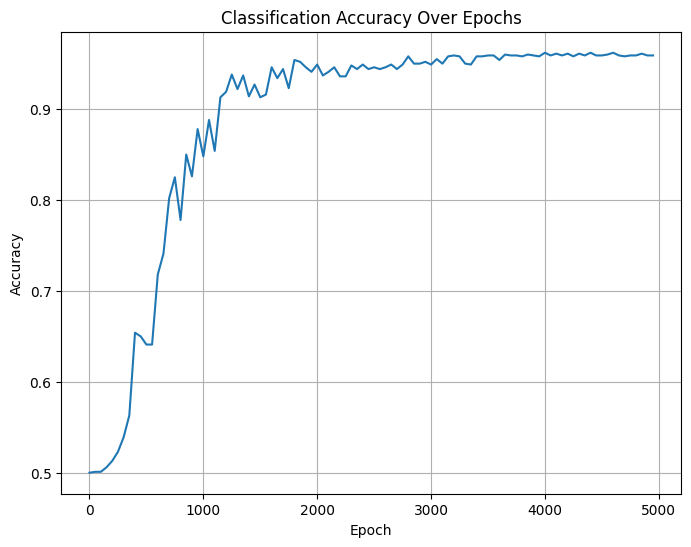

In [53]:
def compute_accuracy(X, Y, w, b):
    """
    Compute classification accuracy over all epochs.
    X: Input data (torch.Tensor of shape [num_samples, 2])
    Y: True labels (torch.Tensor of shape [num_samples])
    w: Weights tensor of shape (2, 2, num_epochs)
    b: Bias tensor of shape (1, 2, num_epochs)
    """
    num_epochs = w.shape[2]
    accuracies = []

    for epoch in range(num_epochs):
        weight_loc = w[:, 0, epoch]  # Mean weights
        bias_loc = b[0, 0, epoch]    # Mean bias

        # Compute logits
        logits = X @ weight_loc + bias_loc

        # Convert logits to predictions
        predictions = (torch.sigmoid(logits) >= 0.5).int()

        # Calculate accuracy
        accuracy = (predictions == Y.squeeze()).float().mean().item()
        accuracies.append(accuracy)


    return np.array(accuracies)

# Calculate accuracy over epochs
accuracies = compute_accuracy(X_tensor, y_tensor, w, b)

# Plot the accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(0, 50*len(accuracies) , 50), accuracies, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy Over Epochs')
plt.grid(True)
plt.show()
